In [1]:
import io
import os
from datetime import datetime

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds

tf.get_logger().setLevel("ERROR")

from tensorflow import keras
from keras import layers

import sklearn.neighbors as sk_neighbors
import sklearn.model_selection as sk_model

import numpy as np
import pandas as pd

from skimage import filters

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm
import sklearn

import warnings
warnings.filterwarnings("ignore")

Training dataset: 5994
Test dataset: 5794


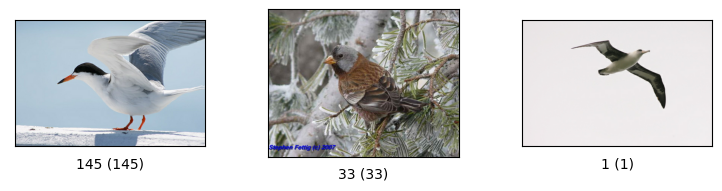

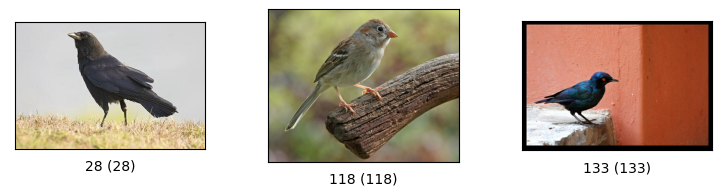

In [2]:
# Settings
batch_size = 16
img_width = 320
img_height = 320

# Fetch dataset
(train_ds_original, test_ds_original), ds_info = tfds.load(
    "caltech_birds2011", 
    split=["train", "test"], 
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

# Display dataset
print("Training dataset: {0}".format(len(train_ds_original)))
print("Test dataset: {0}".format(len(test_ds_original)))

fig = tfds.show_examples(train_ds_original.take(3), ds_info, image_key="image")
fig = tfds.show_examples(test_ds_original.take(3), ds_info, image_key="image")

In [3]:
# Data augmentation
augmentation = keras.Sequential([
    layers.RandomContrast(factor=0.1),
    layers.RandomFlip(mode="horizontal"),
    layers.RandomRotation(factor=0.1),
    layers.RandomZoom(height_factor=0.1, width_factor=0.1),
    
    layers.Rescaling(scale=1./255),
])

num_classes = 10
filter_labels = lambda image, label: label < num_classes

def modify_images(image, label):
    image = tf.image.convert_image_dtype(image, dtype=tf.float32)
    
    image = tf.image.resize_with_pad(
        image,
        img_height, img_width,
        method="bilinear",
        antialias=False,
    )
    
#     image = augmentation(image)
    return image, label

# Prepear dataset
train_ds = (
    train_ds_original
    .filter(filter_labels)
    .map(modify_images, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .cache()
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

test_ds = (
    test_ds_original
    .filter(filter_labels)
    .map(modify_images, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .cache()
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

In [4]:
# Setup model
model = keras.Sequential([
    # Input
    layers.InputLayer(input_shape=(img_height, img_width, 3)),
    
    # Data augmentation
#     layers.RandomContrast(factor=0.1),
#     layers.RandomFlip(mode="horizontal"),
#     layers.RandomRotation(factor=0.1),
#     layers.RandomZoom(height_factor=0.1, width_factor=0.1),
    
#     layers.Rescaling(scale=1./255),

    # Block 1
    layers.BatchNormalization(),
    layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same"),
    layers.MaxPool2D(),

    # Block 2
    layers.BatchNormalization(),
    layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same"),
    layers.MaxPool2D(),

#     # Block 3
#     layers.BatchNormalization(),
#     layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same"),
#     layers.MaxPool2D(),
    
#     # Block 4
#     layers.BatchNormalization(),
#     layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same"),
#     layers.Conv2D(filters=256, kernel_size=3, activation="relu", padding="same"),
#     layers.MaxPool2D(),

    # Head
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(256, activation=None),
    layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)),
])

# Summarize model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 320, 320, 3)      12        
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 320, 320, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 160, 160, 64)     0         
 )                                                               
                                                                 
 batch_normalization_1 (Batc  (None, 160, 160, 64)     256       
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 160, 160, 128)     73856     
                                                      

In [5]:
# Prepear model
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletHardLoss(margin=1.4),
)

# Train model
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=8,
)

Epoch 1/8
19/19 [==============================] - 11s 315ms/step - loss: 1.6558 - val_loss: 1.5502
Epoch 2/8
19/19 [==============================] - 2s 123ms/step - loss: 1.4996 - val_loss: 1.4804
Epoch 3/8
19/19 [==============================] - 2s 125ms/step - loss: 1.3983 - val_loss: 1.4714
Epoch 4/8
19/19 [==============================] - 2s 123ms/step - loss: 1.2501 - val_loss: 1.4654
Epoch 5/8
19/19 [==============================] - 2s 124ms/step - loss: 1.1099 - val_loss: 1.4679
Epoch 6/8
19/19 [==============================] - 2s 124ms/step - loss: 0.9746 - val_loss: 1.4564
Epoch 7/8
19/19 [==============================] - 2s 124ms/step - loss: 0.8591 - val_loss: 1.4576
Epoch 8/8
19/19 [==============================] - 2s 125ms/step - loss: 0.8029 - val_loss: 1.4619


<AxesSubplot: >

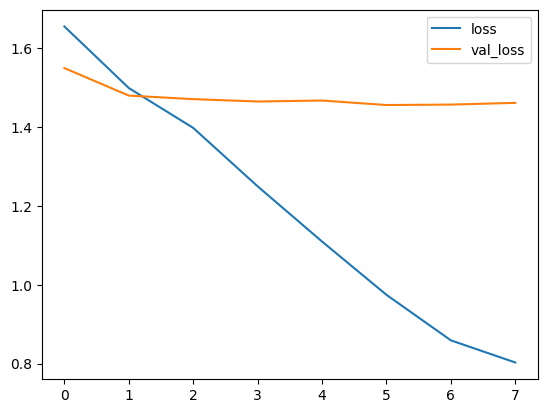

In [6]:
# Plot learning curves
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ["loss", "val_loss"]].plot()

In [7]:
# Test network
test_dataset = train_ds

results = model.predict(test_dataset)

time_sufix = datetime.now().strftime("%H:%M:%S")
np.savetxt("output/vecs-" + time_sufix + ".tsv", results, delimiter="\t")

out_m = io.open("output/meta-" + time_sufix + ".tsv", "w", encoding="utf-8")
for img, labels in tfds.as_numpy(test_dataset):
    [out_m.write(str(x) + "\n") for x in labels]
out_m.close()

19/19 [==============================] - 0s 19ms/step


In [8]:
# Extract embiddings
def get_embeddings_and_labels(dataset):
    embaddings = model.predict(dataset)
    labels = np.concatenate([y.numpy() for x, y in dataset])
    assert embaddings.shape[0] == labels.shape[0]
    return embaddings, labels

train_embeddings, train_labels = get_embeddings_and_labels(train_ds)
val_embeddings, val_labels = get_embeddings_and_labels(test_ds)

16/16 [==============================] - 0s 18ms/step


In [9]:
# Train KNN
knn_finder = sk_model.GridSearchCV(
    sk_neighbors.KNeighborsClassifier(), 
    param_grid={
        "n_neighbors": [1,2,3,4,5,6,7], 
        "weights": ["uniform", "distance"],
    },
    n_jobs=-1,
)

_ = knn_finder.fit(train_embeddings, train_labels)

In [10]:
# Get training and validation acuuracy
knn_train_score = knn_finder.best_estimator_.score(train_embeddings, train_labels)
knn_val_score = knn_finder.best_estimator_.score(val_embeddings, val_labels)

print("Training:   {:.2f}%".format(knn_train_score * 100))
print("Validation: {:.2f}%".format(knn_val_score * 100))

Training:   100.00%
Validation: 18.52%


In [11]:
# Extract embadings
def embading_distances(embeddings, labels, samples):
    dist = tf.keras.metrics.MSE
    
    all_classes = np.unique(labels)

    pos_dists = []
    for i in tqdm(range(samples)):
#         idx = int(np.random.uniform(0, 1000))
        idx = np.random.choice(all_classes)
        possible_idxs = np.where(labels == idx)[0]
        choose_idx = np.random.choice(possible_idxs, size=2)

        d = dist(embeddings[choose_idx[0]], embeddings[choose_idx[1]])
        pos_dists.append(d)

    neg_dists = []
    for i in tqdm(range(samples)):
#         idx = int(np.random.uniform(0, 1000))
        idx = np.random.choice(all_classes)
        other_idxs = np.where(labels != idx)[0]
        choose_idx = np.random.choice(other_idxs, size=1)

        d = dist(embeddings[idx], embeddings[choose_idx[0]])
        neg_dists.append(d)
        
    pos_dists, neg_dists = sklearn.utils.shuffle(pos_dists, neg_dists)
    return pos_dists, neg_dists


num_samples = 2*10e2

train_pos_dists, train_neg_dists = embading_distances(train_embeddings, train_labels, samples=int(num_samples))
val_pos_dists, val_neg_dists = embading_distances(val_embeddings, val_labels, samples=int(num_samples))

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [12]:
# Threshold
val_thresh = filters.threshold_otsu(np.concatenate([val_pos_dists, val_neg_dists]))
train_thresh = filters.threshold_otsu(np.concatenate([train_pos_dists, train_neg_dists]))

print(f'Threshold for train set: {train_thresh:0.5f} Threshold for test set: {val_thresh:0.5f} \t Validation threshold {(np.abs(train_thresh - val_thresh) / train_thresh)*100:0.2f}%')

Threshold for train set: 0.00050 Threshold for test set: 0.00035 	 Validation threshold 29.59%


In [13]:
# Evaluate model
train_loss = model.evaluate(train_ds)
val_loss = model.evaluate(test_ds)

print(f'Loss | Train: {train_loss:0.4f} \t Validation: {val_loss:0.4f}')

16/16 [==============================] - 0s 18ms/step - loss: 1.4619
Loss | Train: 1.3584 	 Validation: 1.4619


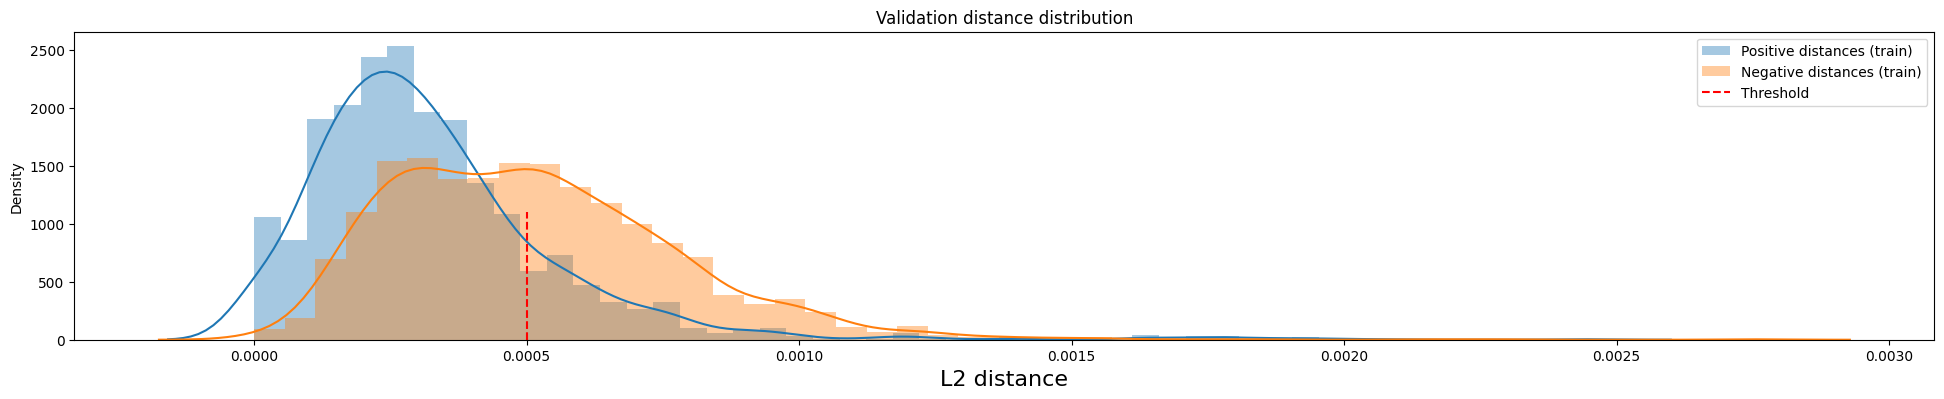

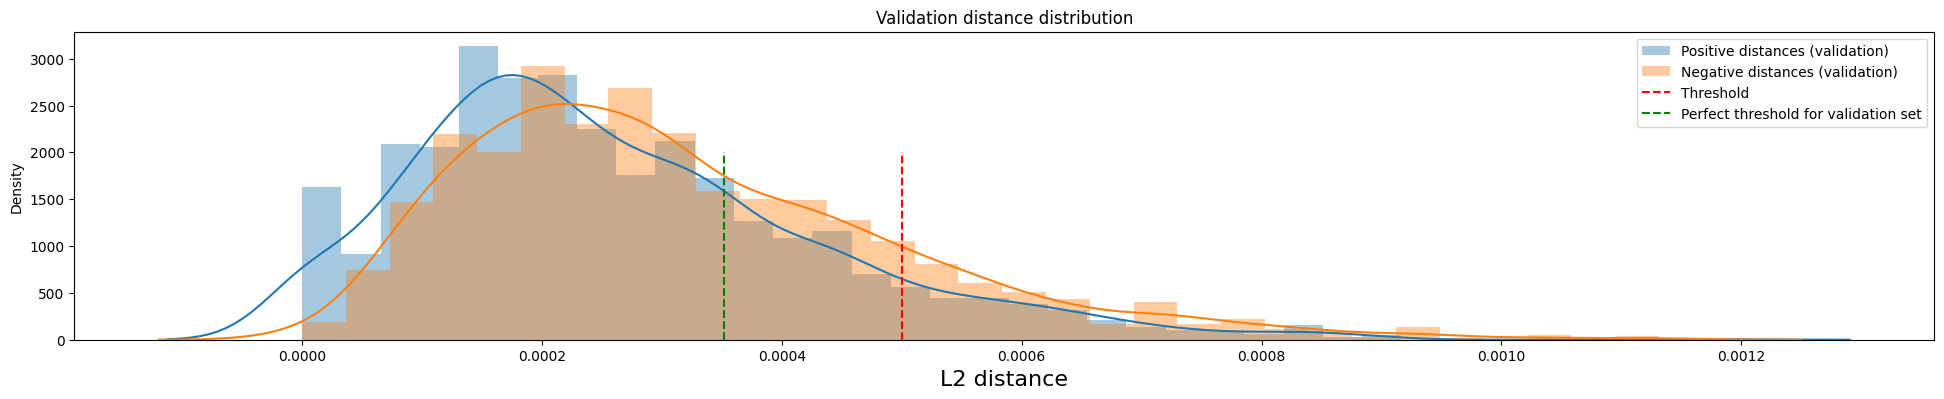

In [14]:
fig, ax = plt.subplots(figsize=(24, 4))

sns.distplot(train_pos_dists, label='Positive distances (train)')
sns.distplot(train_neg_dists, label='Negative distances (train)')

ax.vlines(train_thresh, 0, 1100, color='r', linestyle='--', label='Threshold')
ax.set_title('Validation distance distribution')

ax.set_xlabel('L2 distance', fontsize=16)
ax.legend();

plt.show()


fig, ax = plt.subplots(figsize=(24, 4))

sns.distplot(val_pos_dists, label='Positive distances (validation)')
sns.distplot(val_neg_dists, label='Negative distances (validation)')

ax.vlines(train_thresh, 0, 2000, color='r', linestyle='--', label='Threshold')
ax.vlines(val_thresh, 0, 2000, color='g', linestyle='--', label='Perfect threshold for validation set')

ax.set_xlabel('L2 distance', fontsize=16)
ax.legend()
ax.set_title('Validation distance distribution')

plt.show()